<a href="https://colab.research.google.com/github/agusekominarno/CBIR-MTCD/blob/main/MTCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import All Necessary Library**

In [ ]:
!wget https://github.com/agusekominarno/Batik/blob/master/Dataset/Batik300.zip
!unzip -qq Batik300.zip
%cd Batik300

In [ ]:
from pylab import *
from sklearn.metrics import precision_recall_fscore_support
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics.cluster import entropy
from collections import Counter
import random
import numpy as np
import cv2
import glob
import csv
import math
import scipy.spatial.distance as dist

In [ ]:
def colorQuantization(colorChannelImage, bins, max_color = 255):
    # change color variance to bins variance
    quant = np.array(colorChannelImage) * (bins / max_color)
    quant = np.floor(quant)
    quant[quant>=bins] = bins - 1
    
    return quant

In [ ]:
def combineColorQuantization(image, B_bins, G_bins, R_bins):
    # extract matrix of color channel image
    B = image[:,:,0]
    G = image[:,:,1]
    R = image[:,:,2]
    
    # kuantisasikan tiap color channel
    B_quant = colorQuantization(B, B_bins) # bisa coba diganti dengan K-Means
    G_quant = colorQuantization(G, G_bins)
    R_quant = colorQuantization(R, R_bins)
    
    # combine the color quantization
    combine_quant = (B_bins * G_bins * R_quant) + (B_bins * G_quant) + B_quant
    
    return combine_quant

In [ ]:
def edgeQuantization(image, binsTheta) :
    # extract matrix of color channel image
    B = image[:,:,0]
    G = image[:,:,1]
    R = image[:,:,2]

    # sobel implementation
    Bx = cv2.Sobel(B,cv2.CV_64F,1,0,ksize=3)
    By = cv2.Sobel(B,cv2.CV_64F,0,1,ksize=3)
    Gx = cv2.Sobel(G,cv2.CV_64F,1,0,ksize=3)
    Gy = cv2.Sobel(G,cv2.CV_64F,0,1,ksize=3)
    Rx = cv2.Sobel(R,cv2.CV_64F,1,0,ksize=3)
    Ry = cv2.Sobel(R,cv2.CV_64F,0,1,ksize=3)

    # get |a| and |b|
    a = sqrt(Bx**2 + Gx**2 + Rx**2)
    b = sqrt(By**2 + Gy**2 + Ry**2)

    # get ab
    ab = (Bx*By) + (Gx*Gy) + (Rx*Ry)

    # image orientation
    (h, w) = a.shape
    #binsTheta = 18
    theta = np.zeros((h,w))

    # edge quantization
    for i in range (0, h) :
        for j in range (0, w) :
            if (a[i,j] == 0 or b[i,j] == 0):
                cosab1 = 0;
            else :
                cosab1 = ab[i,j]/(a[i,j]*b[i,j])
            theta1 = math.degrees(np.arccos(cosab1))
            if (math.isnan(theta1)):
                theta1 = 0
            theta[i,j] = math.floor(theta1 * (binsTheta/180))
            if (theta[i,j] >= binsTheta-1) :
                theta[i,j] = binsTheta-1
    
    return np.array(theta)

In [ ]:
def textonSearch(colorQuant, cBins, edgeQuant, eBins) :
    # define the shape of image
    (h, w) = colorQuant.shape

    # untuk menangani image yang dimensinya ganjil
    if (h % 2 == 1):
        a = np.zeros((h+1,w))
        colorQuant = colorQuant[:-1,:]
        edgeQuant = edgeQuant[:-1,:]

    if (w % 2 == 1):
        a = np.zeros((h,w+1))
        colorQuant = colorQuant[:,:-1]
        edgeQuant = edgeQuant[:,:-1]

    (h, w) = colorQuant.shape
    color_img = np.zeros((h,w))
    edge_img = np.zeros((h,w))
    
    # sliding window check for all color channel
    for i in range (0, h, 2) :
        for j in range (0, w, 2) :
            
            # texton search for color
            cTemp = colorQuant[i:i+2,j:j+2]
            if (cTemp[0,0] == cTemp[0,1]) :    # texton type 1
                color_img[i,j] = colorQuant[i,j]
                color_img[i,j+1] = colorQuant[i,j+1]
            if (cTemp[0,0] == cTemp[1,0]) :    # texton type 2
                color_img[i,j] = colorQuant[i,j]
                color_img[i+1,j] = colorQuant[i+1,j]
            if (cTemp[0,0] == cTemp[1,1]) :    # texton type 3
                color_img[i,j] = colorQuant[i,j]
                color_img[i+1,j+1] = colorQuant[i+1,j+1]
            if (cTemp[1,0] == cTemp[1,1]) :    # texton type 4
                color_img[i+1,j] = colorQuant[i+1,j]
                color_img[i+1,j+1] = colorQuant[i+1,j+1]
            if (cTemp[0,1] == cTemp[1,1]) :    # texton type 5
                color_img[i,j+1] = colorQuant[i,j+1]
                color_img[i+1,j+1] = colorQuant[i+1,j+1]
            if (cTemp[0,1] == cTemp[1,0]) :    # texton type 6
                color_img[i,j+1] = colorQuant[i,j+1]
                color_img[i+1,j] = colorQuant[i+1,j]
                
            # texton search for edge
            eTemp = edgeQuant[i:i+2,j:j+2]
            if (eTemp[0,0] == eTemp[0,1]) :    # texton type 1
                edge_img[i,j] = edgeQuant[i,j]
                edge_img[i,j+1] = edgeQuant[i,j+1]
            if (eTemp[0,0] == eTemp[1,0]) :    # texton type 2
                edge_img[i,j] = edgeQuant[i,j]
                edge_img[i+1,j] = edgeQuant[i+1,j]
            if (eTemp[0,0] == eTemp[1,1]) :    # texton type 3
                edge_img[i,j] = edgeQuant[i,j]
                edge_img[i+1,j+1] = edgeQuant[i+1,j+1]
            if (eTemp[1,0] == eTemp[1,1]) :    # texton type 4
                edge_img[i+1,j] = edgeQuant[i+1,j]
                edge_img[i+1,j+1] = edgeQuant[i+1,j+1]
            if (eTemp[0,1] == eTemp[1,1]) :    # texton type 5
                edge_img[i,j+1] = edgeQuant[i,j+1]
                edge_img[i+1,j+1] = edgeQuant[i+1,j+1]
            if (eTemp[0,1] == eTemp[1,0]) :    # texton type 6
                edge_img[i,j+1] = edgeQuant[i,j+1]
                edge_img[i+1,j] = edgeQuant[i+1,j]
    
    # make color histogram
    cF = np.histogram(color_img.ravel(),cBins,[0,64])
    colorFeatures = (np.array(cF[0]) / 6) # perlu dibagi dg 6 meyesuaikan dg jumlah type texton yg digunakan
    
    # make edge histogram
    eF = np.histogram(edge_img.ravel(),eBins,[0,18])
    edgeFeatures = (np.array(eF[0]) / 6)
    
    # combine color and edge features
    features = []
    features.extend(colorFeatures)
    features.extend(edgeFeatures)
    
    return features

In [ ]:
def GLCM(image) :
    # convert iamge to greyscale
    grey_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # make co-occurance matrix
    gm = greycomatrix(grey_img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, normed=True)
    (h,w) = gm[:,:,0,0].shape
    
    glcm_features = []
    
    # calculate energy, contrast, correlation, entropy
    # using scikit library
    
    energy = greycoprops(gm, 'energy')
    contrast = greycoprops(gm, 'contrast')
    correlation = greycoprops(gm, 'correlation')
    glcm_features.extend(energy.tolist())
    glcm_features.extend(contrast.tolist())
    glcm_features.extend(correlation.tolist())
    
    entropy = []
    for i in range (0, 4):
        e = np.abs(gm[:,:,0,i]*np.log2(gm[:,:,0,i]))
        e[isnan(e)] = 0
        entropy.append(sum(e))
    
    return glcm_features, entropy

In [ ]:
# import the necessary packages
import numpy as np
import csv

class Searcher:
    def __init__(self, indexPath):
        # store the index path
        self.indexPath = indexPath
        
    def search(self, queryFeatures, limit=5):
        # initialize our dictionary of results
        results = {}
    
        # open the index file for reading
        with open(self.indexPath) as f:
            # initialize the csv reader
            reader = csv.reader(f)
            
            # loop over the rows in the index
            for row in reader:
                # parse out the image ID and features, then compute the chi-squared
                # distance between the features in our index and our query features
                features = [float(x) for x in row[1:]]
                d = self.canberra_distance(features, queryFeatures)
                
                # now that we have the distance between the two feature vectors,
                # we can update the result dictionary -- the key is the current
                # image ID in the index and the value is the distance we just
                # computed, representing how 'similar' the image in the index is to our query
                results[row[0]] = d
                
            # close the reader
            f.close()
            
        # sort our results, so that the smaller distance (i.e. the more relevant images
        # are at the front of the list)
        results = sorted([(v,k) for (k,v) in results.items()])
        
        # return our (limited) results
        return results[:limit]
    
    def canberra_distance(self, histA, histB):
        #d = dist.canberra(histA, histB)

        # modified canberra
        M = len(histA)
        mA = mean(histA)
        mB = mean(histB)
        d = 0
        for i in range (0, M) :
            d = d + ( abs(histA[i] - histB[i]) / 
               ((abs(histA[i] + mA) + abs(histB[i] + mB))))

        return d

**Build Data Indexing**

In [ ]:
# Describe path of data train and index file
datatrain_path = root_path + "batik"
indexfile_path = root_path + "batikIndex.csv"

# define the bins for quantization
colorBins = 64
R_Bins = 4
G_Bins = 4
B_Bins = 4
edgeBins = 18

# open the output index file for writing
output = open(indexfile_path, 'w')

# use glob to grab the image paths and logo over them
for imagePath in glob.glob(datatrain_path+'/*.jpg'):
    # extract the image ID (i.e. the unique filename) from the image path and load the image itself
    imageID = imagePath[imagePath.rfind('/') + 1:]
    image = cv2.imread(imagePath)
    
    # Color Quantization
    colorQuant = combineColorQuantization(image, B_Bins, G_Bins, R_Bins)

    # Edge Quantization
    edgeQuant = edgeQuantization(image, edgeBins)
    
    # Texton Search
    #features = []
    features = textonSearch(colorQuant, colorBins, edgeQuant, edgeBins)
    
    # GLCM
    glcm, en = GLCM(image)
    
    # write the features to file
    #features.extend(glcm)
    features.extend(glcm[0])
    features.extend(glcm[1])
    features.extend(glcm[2])
    features.extend(en)
    features = [str(f) for f in features]
    output.write('%s,%s\n' % (imageID, ','.join(features)))

print('Finish indexing. Alhamdulillah...')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in arccos
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


Finish indexing. Alhamdulillah...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in arccos
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


[]


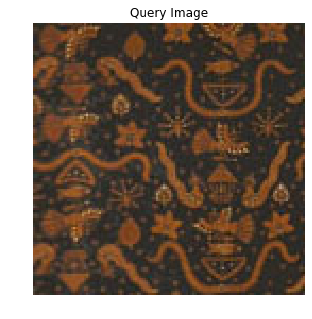

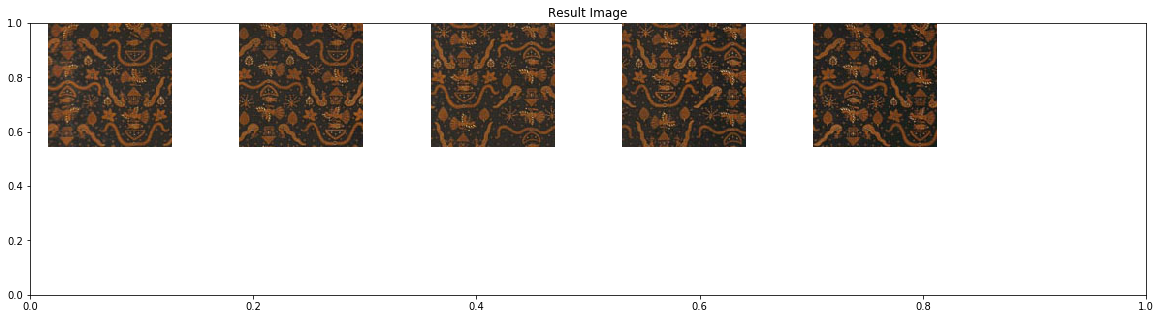

In [ ]:
from PIL import Image

# Define path of testing data and indexing file
queryPath = root_path + '2.jpg'
index_file = root_path + 'mtcd.csv'

# define the bins for quantization
colorBins = 64
R_Bins = 4
G_Bins = 4
B_Bins = 4
edgeBins = 18

query = cv2.imread(queryPath)

# Color Quantization
colorQuant = combineColorQuantization(query, B_Bins, G_Bins, R_Bins)

# Edge Quantization
edgeQuant = edgeQuantization(query, edgeBins)
    
# Texton Search
features = textonSearch(colorQuant, colorBins, edgeQuant, edgeBins)
    
# GLCM
glcm, en = GLCM(query)

features.extend(glcm[0])
features.extend(glcm[1])
features.extend(glcm[2])
features.extend(en)

# perform the search
searcher = Searcher(index_file)
results = searcher.search(features)

# display the query
fig = figure(figsize=(5,5))
title('Query Image')
imshow(array(Image.open(queryPath)))
axis('off')

# loop over the results
fig = figure(num=None, figsize=(20,5))
title('Result Image')
result = []
i = 1
for (score, resultID) in results:
    # load the result image and display it
    a = fig.add_subplot(2, 6, i)
    image = imread(root_path + 'batik/'+resultID)
    i += 1
    imshow(image)
    axis('off')
print(result)